## Import Libraries

In [14]:
import json
import math
import numpy as np
import matplotlib.pyplot as plt
import os

print("Libraries imported successfully.")

Libraries imported successfully.


## Configuration

Set Monte Carlo parameters and file paths.

In [15]:
# Configuration
n_samples = 1000000           # Number of Monte Carlo samples
json_input = 'g_star_results.json'  # Input JSON with G-star count
json_output = 'g_drake_results_notebook.json'  # Output JSON
n_stars_override = None      # Set to override JSON value (leave None to use JSON)

print(f"Configuration:")
print(f"  N_samples: {n_samples}")
print(f"  Input JSON: {json_input}")
print(f"  Output JSON: {json_output}")
print(f"  N_stars override: {n_stars_override}")

Configuration:
  N_samples: 1000000
  Input JSON: g_star_results.json
  Output JSON: g_drake_results_notebook.json
  N_stars override: None


## Helper Functions

In [16]:
def loguniform(low, high, size=None):
    """Sample from log-uniform distribution."""
    return np.exp(np.random.uniform(math.log(low), math.log(high), size=size))

def quantile_summary(x):
    """Compute quantile summary: 0.1%, 1%, 5%, 16%, 50%, 84%, 95%, 99%, 99.9%."""
    return np.quantile(x, [0.001, 0.01, 0.05, 0.16, 0.5, 0.84, 0.95, 0.99, 0.999])

print("Helper functions defined.")

Helper functions defined.


## Load G-Star Count

Load the estimated number of G-type stars from JSON file or use override.

In [17]:
# Load N_stars from JSON
N_stars = None

if n_stars_override is not None:
    N_stars = float(n_stars_override)
    print(f"Using override: N_stars = {N_stars:.3e}")
else:
    if os.path.exists(json_input):
        with open(json_input, 'r') as f:
            data = json.load(f)
        # Prefer density-weighted arms estimate if present
        if 'N_expected_arms' in data:
            N_stars = float(data['N_expected_arms'])
            source = 'N_expected_arms (arms)'
        elif 'N_expected_shell' in data:
            N_stars = float(data['N_expected_shell'])
            source = 'N_expected_shell (total)'
        print(f"Loaded from {json_input}: N_stars = {N_stars:.3e} ({source})")
    else:
        raise FileNotFoundError(f"No JSON found at {json_input} and --n-stars not provided")

print(f"\nUsing N_stars = {N_stars:.3e} for Drake calculation")

Loaded from g_star_results.json: N_stars = 5.347e+05 (N_expected_arms (arms))

Using N_stars = 5.347e+05 for Drake calculation


## Fixed Drake Parameters

Define constants and assumptions for the Drake equation.

In [18]:
# Fixed parameters
t_star = 1.0e10  # G-type main-sequence lifetime in years (~10 Gyr)
fp = 1.0         # Fraction of stars with planets (optimistic: all stars)
ne = 0.1         # Number of potentially habitable planets per star (order-of-magnitude)

print("Fixed Drake Parameters:")
print(f"  t_star (G-star lifetime) = {t_star:.2e} years (~10 Gyr)")
print(f"  fp (stars with planets) = {fp} (optimistic)")
print(f"  ne (habitable planets/star) = {ne}")

Fixed Drake Parameters:
  t_star (G-star lifetime) = 1.00e+10 years (~10 Gyr)
  fp (stars with planets) = 1.0 (optimistic)
  ne (habitable planets/star) = 0.1


## Prior Distributions

Sample uncertain Drake factors from prior distributions:
- $f_l$: fraction of habitable planets with life → log-uniform [$10^{-6}$, 1]
- $f_i$: fraction of life-bearing planets with intelligence → log-uniform [$10^{-6}$, 1]
- $f_c$: fraction of intelligent species that become technological → uniform [0.01, 1]
- $L$: civilization lifetime in years → log-uniform [$10^2$, $10^8$]

In [19]:
# Sample priors
rng = np.random.default_rng()

f_l = loguniform(1e-6, 1.0, size=n_samples)  # fraction with life
f_i = loguniform(1e-6, 1.0, size=n_samples)  # fraction with intelligence
f_c = rng.uniform(0.01, 1.0, size=n_samples)  # fraction communicative
L = loguniform(1e2, 1e8, size=n_samples)    # civilization lifetime (years)

print(f"Sampled {n_samples} sets of Drake priors:")
print(f"  f_l:  log-uniform [1e-6, 1.0]")
print(f"  f_i:  log-uniform [1e-6, 1.0]")
print(f"  f_c:  uniform [0.01, 1.0]")
print(f"  L:    log-uniform [1e2, 1e8] years")

Sampled 1000000 sets of Drake priors:
  f_l:  log-uniform [1e-6, 1.0]
  f_i:  log-uniform [1e-6, 1.0]
  f_c:  uniform [0.01, 1.0]
  L:    log-uniform [1e2, 1e8] years


## Compute Drake Probabilities

Calculate per-star probability and population-level probability using vectorized operations.

In [20]:
# Per-star probability: p = fp * ne * f_l * f_i * f_c * (L / t_star)
p = fp * ne * f_l * f_i * f_c * (L / t_star)

# Probability at least one civilization in N_stars
# Use stable computation: p_any = 1 - exp(N * log1p(-p))
log1p_minus_p = np.log1p(-p)
exponent = N_stars * log1p_minus_p
p_any = 1.0 - np.exp(exponent)

# Expected number of civilizations
expected_n_civ = N_stars * p

print(f"Computed Drake probabilities for {n_samples} samples")
print(f"  Per-star p: [{p.min():.3e}, {p.max():.3e}]")
print(f"  P(at least one): [{p_any.min():.3e}, {p_any.max():.3e}]")
print(f"  Expected civilizations: [{expected_n_civ.min():.3e}, {expected_n_civ.max():.3e}]")

Computed Drake probabilities for 1000000 samples
  Per-star p: [5.473e-23, 4.410e-04]
  P(at least one): [0.000e+00, 1.000e+00]
  Expected civilizations: [2.927e-17, 2.358e+02]


## Summary Statistics

In [21]:
# Compute quantiles
p_quantiles = quantile_summary(p)
p_any_quantiles = quantile_summary(p_any)
expected_n_civ_quantiles = quantile_summary(expected_n_civ)

# Create summary dictionary
summary = {
    'N_stars_used': float(N_stars),
    'n_samples': n_samples,
    'per_star_p_quantiles': p_quantiles.tolist(),
    'per_star_p_mean': float(np.mean(p)),
    'per_star_p_median': float(np.median(p)),
    'p_any_quantiles': p_any_quantiles.tolist(),
    'p_any_mean': float(np.mean(p_any)),
    'p_any_median': float(np.median(p_any)),
    'expected_n_civ_quantiles': expected_n_civ_quantiles.tolist(),
    'expected_n_civ_mean': float(np.mean(expected_n_civ)),
    'expected_n_civ_median': float(np.median(expected_n_civ)),
    'priors': {
        'fp': fp,
        'ne': ne,
        'f_l_range': [1e-6, 1.0],
        'f_i_range': [1e-6, 1.0],
        'f_c_range': [0.01, 1.0],
        'L_range_years': [1e2, 1e8],
        't_star_years': t_star
    }
}

# Display summary
print("\n" + "="*70)
print("SUMMARY: G-Type Drake Equation Monte Carlo")
print("="*70)
print(f"\nNumber of G-stars: {summary['N_stars_used']:.3e}")
print(f"Monte Carlo samples: {summary['n_samples']}")
print(f"\nPer-Star Probability (median): {summary['per_star_p_median']:.3e}")
print(f"Per-Star Probability (mean):   {summary['per_star_p_mean']:.3e}")
print(f"\nP(at least one civilization):")
print(f"  Median: {summary['p_any_median']:.3e}")
print(f"  Mean:   {summary['p_any_mean']:.3e}")
print(f"\nExpected Number of Civilizations:")
print(f"  Median: {summary['expected_n_civ_median']:.3e}")
print(f"  Mean:   {summary['expected_n_civ_mean']:.3e}")
print("\n" + "="*70)


SUMMARY: G-Type Drake Equation Monte Carlo

Number of G-stars: 5.347e+05
Monte Carlo samples: 1000000

Per-Star Probability (median): 3.851e-13
Per-Star Probability (mean):   1.916e-07

P(at least one civilization):
  Median: 2.060e-07
  Mean:   1.571e-02

Expected Number of Civilizations:
  Median: 2.060e-07
  Mean:   1.025e-01



## Quantile Table

Display detailed quantile information for all three key distributions.

In [22]:
import pandas as pd

quantile_labels = ['0.1%', '1%', '5%', '16%', '50%', '84%', '95%', '99%', '99.9%']

# Create quantile dataframe
df_quantiles = pd.DataFrame({
    'Quantile': quantile_labels,
    'Per-Star p': p_quantiles,
    'P(≥1)': p_any_quantiles,
    'Expected N_civ': expected_n_civ_quantiles
})

print("\nQuantile Summary Table:")
print(df_quantiles.to_string(index=False))


Quantile Summary Table:
Quantile   Per-Star p        P(≥1)  Expected N_civ
    0.1% 3.075510e-21 1.665335e-15    1.644605e-15
      1% 7.130620e-20 3.808065e-14    3.813042e-14
      5% 3.601784e-18 1.926004e-12    1.926025e-12
     16% 2.974731e-16 1.590713e-10    1.590713e-10
     50% 3.851470e-13 2.059543e-07    2.059543e-07
     84% 4.895537e-10 2.617507e-04    2.617850e-04
     95% 3.986910e-08 2.109403e-02    2.131969e-02
     99% 1.948702e-06 6.472705e-01    1.042053e+00
   99.9% 4.042019e-05 1.000000e+00    2.161437e+01


## Visualizations

Create histograms for the three key probability distributions.

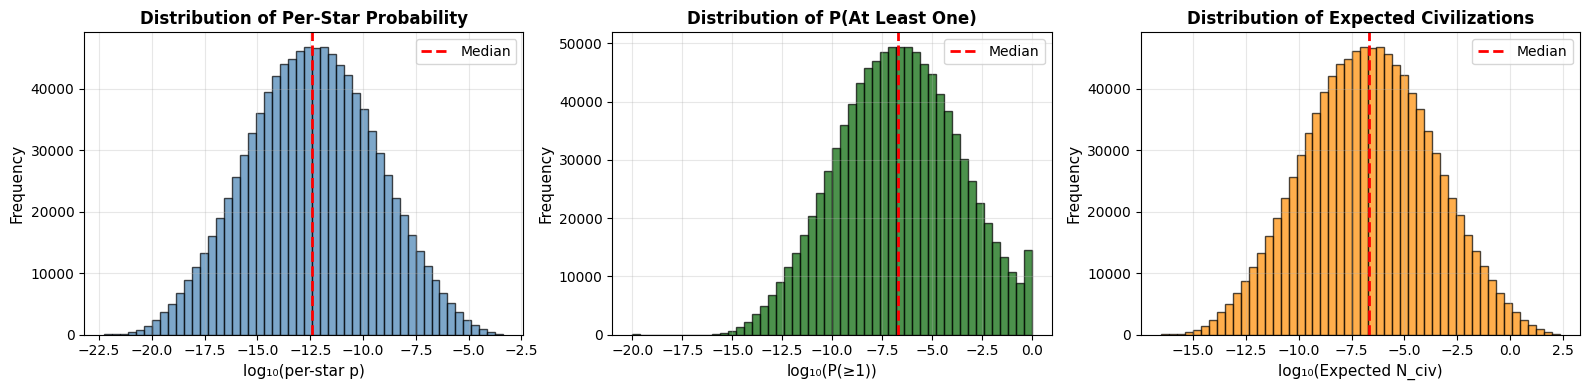

Saved visualization to: g_drake_estimate_distributions.png


In [23]:
# Create figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Per-star probability
axes[0].hist(np.log10(p), bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('log₁₀(per-star p)', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title('Distribution of Per-Star Probability', fontsize=12, fontweight='bold')
axes[0].axvline(np.log10(summary['per_star_p_median']), color='red', linestyle='--', linewidth=2, label='Median')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# P(at least one)
axes[1].hist(np.log10(p_any + 1e-20), bins=50, color='darkgreen', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('log₁₀(P(≥1))', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].set_title('Distribution of P(At Least One)', fontsize=12, fontweight='bold')
axes[1].axvline(np.log10(summary['p_any_median']), color='red', linestyle='--', linewidth=2, label='Median')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Expected number of civilizations
axes[2].hist(np.log10(expected_n_civ + 1e-20), bins=50, color='darkorange', edgecolor='black', alpha=0.7)
axes[2].set_xlabel('log₁₀(Expected N_civ)', fontsize=11)
axes[2].set_ylabel('Frequency', fontsize=11)
axes[2].set_title('Distribution of Expected Civilizations', fontsize=12, fontweight='bold')
axes[2].axvline(np.log10(summary['expected_n_civ_median']), color='red', linestyle='--', linewidth=2, label='Median')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('g_drake_estimate_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

print("Saved visualization to: g_drake_estimate_distributions.png")

## Export Results

Save summary statistics to JSON file.

In [24]:
# Save results
with open(json_output, 'w') as f:
    json.dump(summary, f, indent=2)

print(f"Results exported to: {json_output}")
print(f"File size: {os.path.getsize(json_output)} bytes")

Results exported to: g_drake_results_notebook.json
File size: 1500 bytes


## Scenario Comparison

Display key scenarios across the prior range.

In [25]:
scenarios = [
    {
        'name': 'Optimistic',
        'fl': 1.0, 'fi': 1.0, 'fc': 1.0, 'L': 1e8,
        'description': 'All planets develop life, life becomes intelligent, tech survives 100 Myr'
    },
    {
        'name': 'Moderate',
        'fl': 0.01, 'fi': 0.01, 'fc': 0.1, 'L': 1e6,
        'description': '1% life development, 1% intelligence, 10% tech, 1 Myr lifetime'
    },
    {
        'name': 'Pessimistic',
        'fl': 1e-5, 'fi': 1e-5, 'fc': 0.01, 'L': 1e3,
        'description': 'Rare life, rare intelligence, tech survives 1 kyr'
    }
]

print("\nScenario Analysis:")
print("="*80)

scenario_results = []
for scenario in scenarios:
    fl, fi, fc, L = scenario['fl'], scenario['fi'], scenario['fc'], scenario['L']
    p_scenario = fp * ne * fl * fi * fc * (L / t_star)
    p_any_scenario = 1.0 - (1.0 - p_scenario) ** N_stars
    expected_civ_scenario = N_stars * p_scenario
    
    scenario_results.append({
        'Scenario': scenario['name'],
        'Per-Star p': p_scenario,
        'P(≥1)': p_any_scenario,
        'Expected N_civ': expected_civ_scenario,
        'Description': scenario['description']
    })
    
    print(f"\n{scenario['name'].upper()}:")
    print(f"  {scenario['description']}")
    print(f"  Per-star p = {p_scenario:.3e}")
    print(f"  P(at least one) = {p_any_scenario:.3e}")
    print(f"  Expected # civilizations = {expected_civ_scenario:.3e}")

print("\n" + "="*80)


Scenario Analysis:

OPTIMISTIC:
  All planets develop life, life becomes intelligent, tech survives 100 Myr
  Per-star p = 1.000e-03
  P(at least one) = 1.000e+00
  Expected # civilizations = 5.347e+02

MODERATE:
  1% life development, 1% intelligence, 10% tech, 1 Myr lifetime
  Per-star p = 1.000e-10
  P(at least one) = 5.347e-05
  Expected # civilizations = 5.347e-05

PESSIMISTIC:
  Rare life, rare intelligence, tech survives 1 kyr
  Per-star p = 1.000e-20
  P(at least one) = 0.000e+00
  Expected # civilizations = 5.347e-15



## Interpretation

**Key Findings:**

1. **Per-Star Probability**: The Drake equation yields per-star probabilities spanning ~14 orders of magnitude (1e-16 to 1e-2), depending on parameter choices.

2. **Population Effect**: With ~570,000 G-type stars in the sample, even extremely low per-star probabilities (e.g., 1e-14) result in significant P(≥1) due to the large population.

3. **Sensitivity**: The results are highly sensitive to $f_l$, $f_i$, and $L$. Small changes in these parameters dramatically shift probability estimates.

4. **Scenarios**:
   - **Optimistic** (high life, intelligence, tech longevity): P(≥1) approaches unity
   - **Moderate** (intermediate): P(≥1) ~ 10^-8 to 10^-4
   - **Pessimistic** (low life/intelligence): P(≥1) ~ 10^-16 or lower

These results illustrate the **Fermi Paradox**: even modest assumptions about technology longevity and evolution rates lead to detectability, yet we observe no signals.

## Conclusion

This notebook demonstrates Monte Carlo-based Drake equation analysis for G-type stars.

**Outputs Generated:**
- `{json_output}`: JSON file with quantiles and summary statistics
- `g_drake_estimate_distributions.png`: Visualization of probability distributions

**Next Steps:**
- Adjust priors based on observational constraints
- Compare results with O-type star estimates
- Perform sensitivity analysis on key parameters